In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### preambule

In [86]:
## importing stuff
import os
import pickle
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
import pandas as pd
from islets.Recording import saveMovie
from islets.numeric import power_spectrum, rebin
from islets.utils import saveRois, show_movie
from caiman import movie as cmovie
from matplotlib.colors import LogNorm
import tifffile
from islets.Regions1 import Regions, crawlDict_restr
from islets.numeric import get_sep_th
from general_functions import autocorr2d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from islets.Regions1 import getStatImages
from cv2 import GaussianBlur
from islets.numeric import robust_max

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from ipywidgets import interactive, FloatSlider

In [3]:
# folder = "/data/Sandra/2020/2020_09_21/REC_6_10_min_20Hz_1mM_Ca/"
folder = "/data/Cosmin/DRG_neurons/"

In [4]:
# pathtotifs = [folder+f for f in sorted(os.listdir(folder)) if f.endswith("tif")]

In [5]:
data = {
    "340":   tifffile.imread('/data/Cosmin/DRG_neurons/340nm.tif'),
    "ratio": tifffile.imread('/data/Cosmin/DRG_neurons/Ratio.tif'),
}

In [6]:
freq = 1

In [7]:
%matplotlib inline

In [8]:
movie = cmovie(data["340"],fr=freq)
movie.shape
movie = movie.resize(.5,.5,1)

In [9]:
statImages = getStatImages(movie)

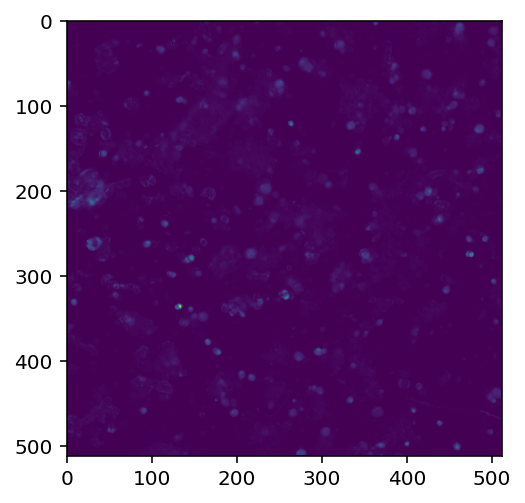

In [10]:
mode="std"
plt.imshow(statImages[mode])

In [394]:
cellSizes = 8

In [395]:
im = statImages[mode].copy()
cellSizes = cellSizes//2*2+1
im = GaussianBlur(im, (cellSizes,)*2,-1)-GaussianBlur(im, (2*cellSizes-1,)*2,-1)
# th0 = im.mean()+3*im.std()

interactive(children=(FloatSlider(value=3.26, description='threshold', max=256.57895223573576, min=-44.2558739…

<IPython.core.display.Javascript object>


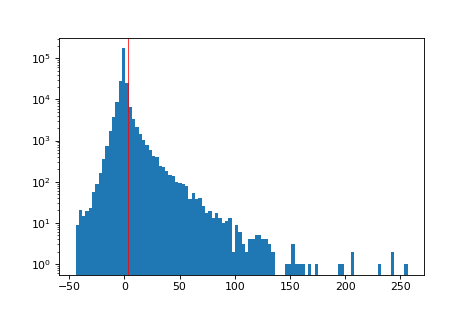

In [396]:
x = im.flatten()
th0 = robust_max(x)*.02
%matplotlib notebook
def f(threshold):
    axline.set_data([threshold]*2,[0,1])
    text.set_text("%.1f%%"%(100*(x>threshold)).mean())
interactive_plot = interactive(f, threshold = FloatSlider(min=x.min(),max=x.max(),value=np.round(th0*100)/100, step = .01))
output = interactive_plot.children[-1]
output.layout.height = '10px'
output.layout.width = '600px'
display(interactive_plot)

ax = plt.subplot(111)
ax.hist(x,100,log=True)
axline = ax.axvline(th0,color="r",lw=.7)
text = ax.text(.95,.99, "",transform=ax.transAxes, ha="right", va="top")
text.set_text("")

In [397]:
th = robust_max(im)*.01
# im[im<th] = 0
%matplotlib inline

In [398]:
regions = Regions({mode:im}, use_restricted=True,verbose=True,mode=mode, img_th=th/robust_max(im), 
#                   gSig_filt=(15,15),
                 )

Initiating from a dictionary assumed to be a dictionary of image stats.
dilating valid pixels by 3
initiating the cralwing dict on 51248 (19.5%) pixels only.


In [399]:
regions.reassign_peaks(statImages["std"])

In [100]:
import plotly_express as plx

In [400]:
regions.df["peak Value"] = np.log(regions.df.peakValue)

In [401]:
fig = plx.scatter(regions.df,x="size",y="peak Value", width=700, height=700,marginal_x="histogram",marginal_y="histogram")
# fig.update_traces(selectedpoints = np.arange(100))
fig

In [402]:
# plt.plot(regions.df["size"], regions.df.peakValue, ".")
# # plt.xscale("log")
# plt.yscale("log")

In [403]:
# col = "size"
# %matplotlib notebook
# def f(logth):
#     axline.set_data([logth]*2,[0,1])
#     for i in range(len(lines)):
#         lines[i].set_color("r" if np.log10(regions.df[col].iloc[i])<logth else "b")
# interactive_plot = interactive(f, logth = FloatSlider(min=np.log10(regions.df[col].min()),max=np.log10(regions.df[col].max()),value=np.log10(regions.df[col].median()), step = .01))
# output = interactive_plot.children[-1]
# output.layout.height = '10px'
# output.layout.width = '400px'

# display(interactive_plot)

# # plt.ion()
# # fig, ax = plt.subplots(1,1,figsize=(6,6))
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_axes([0.51,0.01,.48,.98])
# axin = fig.add_axes([0.05,.15,.4,.6])

# # ax.imshow(regions.statImages[regions.mode], cmap="Greys", norm=LogNorm())
# ax.imshow(statImages[mode], cmap="Greys", norm=LogNorm())
# regions.plotEdges(ax=ax, color="C0", image=False, separate=True)
# lines = ax.lines
# # axin = inset_axes(ax, width="90%", height="90%", loc=4,  bbox_to_anchor=(.01, .7, .4, .3),
# #                       bbox_transform=ax.transAxes,
# #                      )
# axin.plot(sorted(np.log10(regions.df[col])), np.arange(len(regions.df)))
# axin.patch.set_alpha( 0.1)
# for sp in ["top","left","right"]: axin.spines[sp].set_visible(False)
# axin.set_yticks([])
# ax.set_yticks([])
# axin.set_ylim(0,)
# axline = axin.axvline(np.log10(regions.df[col].median()),color="r",lw=.7)

In [404]:
# regions.df = regions.df[regions.df["size"]>10]

In [405]:
regions.update(movie[:,:regions.image.shape[0]])
regions.statImages = statImages

In [406]:
# regions.examine3(
# #     startShow=regions.df.query(f"size<{cellSizes**2/3}").index
# #     startShow="[107, 357, 123, 289, 290, 622, 681, 207, 434, 546, 989, 122, 705, 304, 497, 579, 386, 638, 818, 620, 352, 353, 317, 847, 455, 386, 32, 337, 220, 374, 83, 31, 211, 822, 745, 52, 851, 690, 112, 371, 917, 13, 231, 118, 298, 14, 578, 229, 573, 172, 447, 193, 39, 826, 800, 102, 124, 134, 8, 37, 157, 491, 616, 636, 959, 964, 219, 613, 501, 759, 88, 96, 116, 121, 503, 655, 670, 861, 503, 294, 245, 21, 222, 146, 177, 84, 101, 315, 114, 665, 979, 490, 51, 355, 424, 767, 204, 234, 65, 498, 658, 221, 728, 223, 484, 4, 196, 621, 414, 188, 292, 593, 147, 785, 262, 734, 743, 0, 758, 48, 790, 794, 789, 783, 332, 827, 906, 695, 431, 597, 209, 536, 385, 182, 394, 179, 139, 144, 797, 381, 514, 382, 148, 288, 137, 988, 991, 256, 425, 319, 726, 380, 17, 297, 761, 419, 753, 105, 176, 395, 23, 392, 853, 63, 511, 880, 730, 725, 850, 66, 154, 527, 393, 864, 889, 852, 301, 686, 741, 755, 330, 987, 879, 98, 510, 908, 190, 922, 403, 509, 901, 29, 189, 515, 645, 671, 540, 601, 904, 198, 306, 307, 334, 258, 171, 532, 533, 543, 711, 507, 50, 293, 474, 486, 142, 766, 55, 309, 216, 253, 724, 481, 502, 701, 968, 217, 897, 992, 7, 982, 693, 870, 882, 737, 983, 985, 440, 966, 180, 863, 866, 854, 956, 178, 938, 974, 976, 174, 875, 152, 812, 910, 59, 899, 619, 150, 156, 445, 25, 10, 20, 33, 161, 40, 19, 28, 100, 886, 423, 529, 520, 74, 76, 89, 389, 859, 399, 416, 537, 975, 3, 94, 508, 86, 186, 452, 924, 624, 821, 604, 883, 887, 132, 247, 884, 965, 819, 868, 125, 990, 210, 458, 73, 338, 119, 149, 329, 226, 230, 214, 2, 36, 233, 806, 736, 243, 556, 817, 742, 272, 801, 275, 87, 488, 950, 95, 550, 566, 576, 583, 34, 166, 136, 429, 677, 835, 284, 747, 955, 672, 715, 534, 553, 143, 482, 738, 115, 791, 760, 170, 53, 350, 359, 722, 957, 437, 967, 402, 538, 79, 500, 62, 67, 719, 937, 941, 584, 786, 239, 274, 569, 717, 586, 444, 849, 871, 972, 642, 584, 99, 333, 602, 844, 615, 56, 554, 568, 308, 606, 557, 555, 238, 580, 712, 625, 970, 688, 331, 362, 372, 215, 54, 714, 666, 744, 426, 478, 939, 588, 659, 250, 360, 249, 792, 305, 780, 787, 591, 202, 763, 952, 752, 257, 271, 199, 544, 669, 836, 363, 667, 377, 526, 97, 194, 921, 855, 858, 327, 631, 674, 848, 441, 477, 641, 35, 662, 261, 703, 411, 682, 857, 927, 255, 561, 320, 324, 335, 346, 464, 561, 919, 598, 273, 692, 581, 713, 697, 700, 626, 958, 697, 611, 781, 805, 103, 91, 145, 614, 765, 418, 720, 811, 846, 953, 773, 38, 698, 799, 903, 627, 287, 81, 167, 649, 814, 947, 552, 358, 367, 366, 151, 699, 70, 232, 126, 316, 400, 740, 545, 823, 70, 687]"
#                 )

In [407]:
regions.detrend_traces()

In [408]:
X = np.vstack(regions.df.detrended)

In [409]:
from scipy.stats import median_absolute_deviation

In [410]:
for i in range(len(X)):
    X[i] = X[i]-np.median(X[i])
    X[i] /= median_absolute_deviation(X[i])

In [411]:
# plt.imshow(rebin(X,10,1),aspect="auto")

In [412]:
from sklearn.cluster import KMeans

In [413]:
kmeans = KMeans(6)

In [414]:
# kmeans.fit(X)
# kmeans.fit(X[:,:200])
# kmeans.fit(np.diff(rebin(X,3,1),1))

frqs, pws = power_spectrum(X,fr=1, mean=False)
pws = np.abs(pws)
pws = rebin(pws,2,1)
kmeans.fit(pws)

KMeans(n_clusters=6)

In [415]:
# kmeans.transform(X)

In [416]:
regions.df["clusterID"] = kmeans.labels_

In [417]:
sortedClusterIDs = np.argsort([np.diff(np.vstack(df_clID.trace),1).std() for i,df_clID in regions.df.groupby("clusterID")])

In [418]:
sortedIndices = np.hstack([regions.df.query(f"clusterID=={i}").index for i in sortedClusterIDs])

In [419]:
colors = ["blue","orange","green","red","purple","brown","black"]#[el["color"] for el in c.__dict__["_left"]]

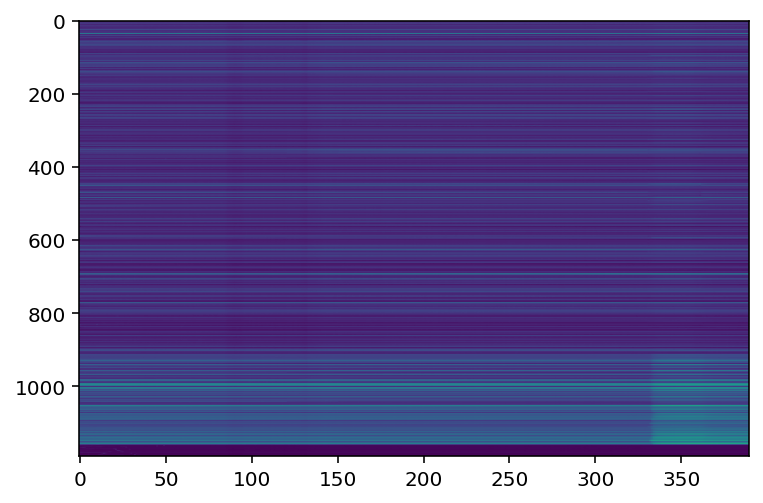

In [420]:
x = np.vstack(regions.df.trace.loc[sortedIndices])
plt.imshow(x,aspect="auto")

In [423]:
regions.df["color"] = [colors[i] for i in regions.df.clusterID]

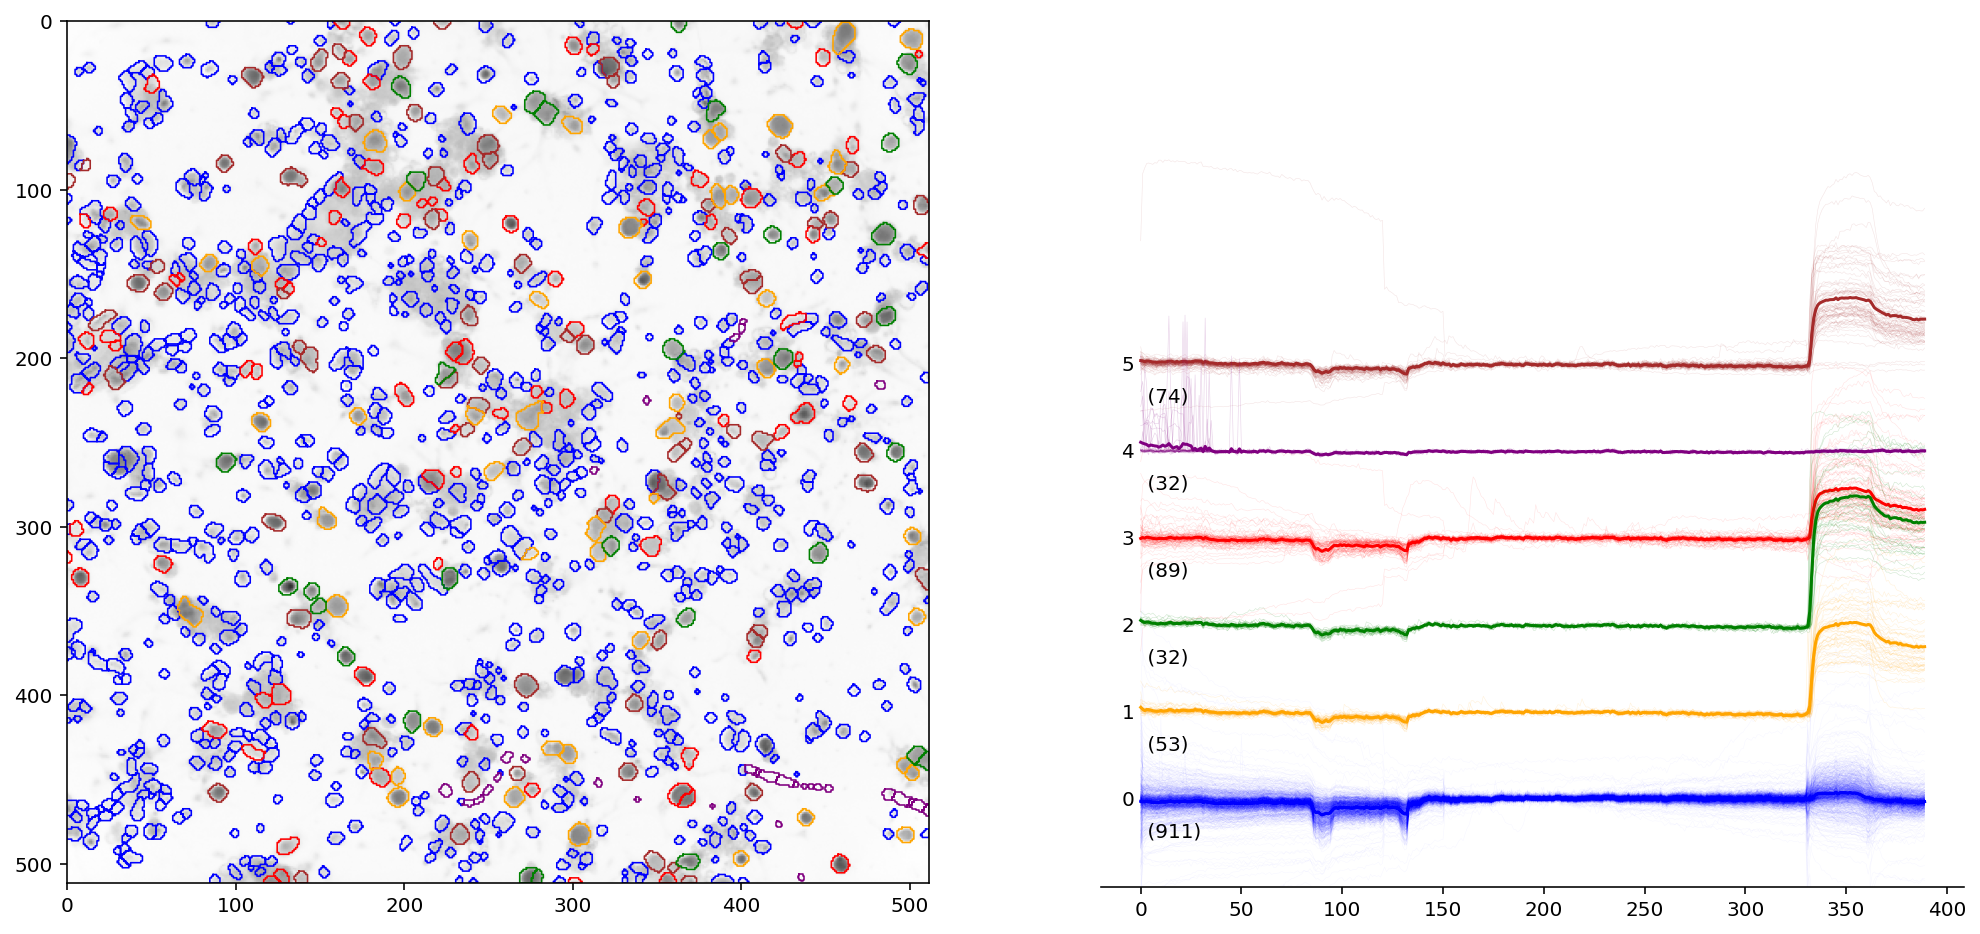

In [421]:
fig, axs = plt.subplots(1,2,figsize=(17,8))
image = statImages["highperc"]
axs[0].imshow(image,cmap="Greys",norm=LogNorm(vmax=image.max()*2), )
for i in sortedClusterIDs:
    df = regions.df.query(f"clusterID=={i}")
    c = colors[i]
    regions.plotEdges(color=c,ix=df.index,ax=axs[0], image=False)
    x = np.vstack(df.trace)
    xm = x.mean(0)
    xm = xm - np.median(xm)
    offset = 200*i
    xm += offset
    axs[1].plot(regions.time, xm, label=f"{i} ({len(df)})",c=c)
    axs[1].text(0,offset,f"{i} ",ha="right",va="center")
    axs[1].text(0,offset,f"\n ({len(df)})",va="top")
#     axs[1].set_xlim(None, regions.time[-1]*1.05)
    for sp in ["right","top","left"]: axs[1].spines[sp].set_visible(False)
#     axs[1].set_yticks([])
    for xx in x:
        xx += offset-np.median(xx)
        axs[1].plot(regions.time, xx, c=c,lw=.3, alpha=1/len(df)**.5)
    plt.yticks([])
    plt.ylim(-200,len(sortedClusterIDs+1)*300)
# plt.legend()

In [424]:
regions.examine3()

/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:504: RuntimeWarning:

invalid value encountered in greater



In [425]:
%matplotlib notebook

<IPython.core.display.Javascript object>


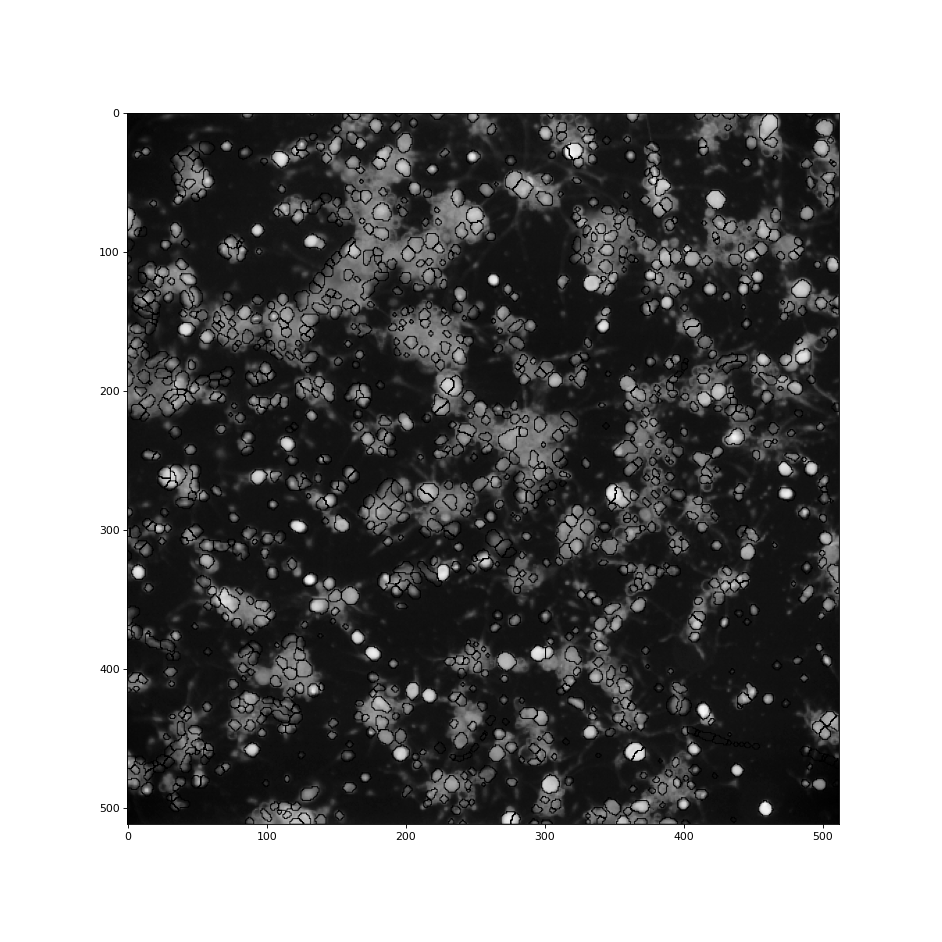

/home/jupyter-srdjan/srdjan_functs/islets/Regions1.py:351: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



In [426]:
plt.figure(figsize=(12,12))
plt.imshow(rebin(rebin(data["340"].mean(0),2),2,1), cmap="Greys_r", norm=LogNorm())
regions.plotEdges(image=False,separate=False)

In [374]:
# from islets.numeric import clusterCutAndPlot

# clst=clusterCutAndPlot(np.diff(X,1), mode="agglomerative")
x = np.vstack([np.mean(regions.df.query(f"clusterID=={i}").trace,0) for i in sortedClusterIDs])

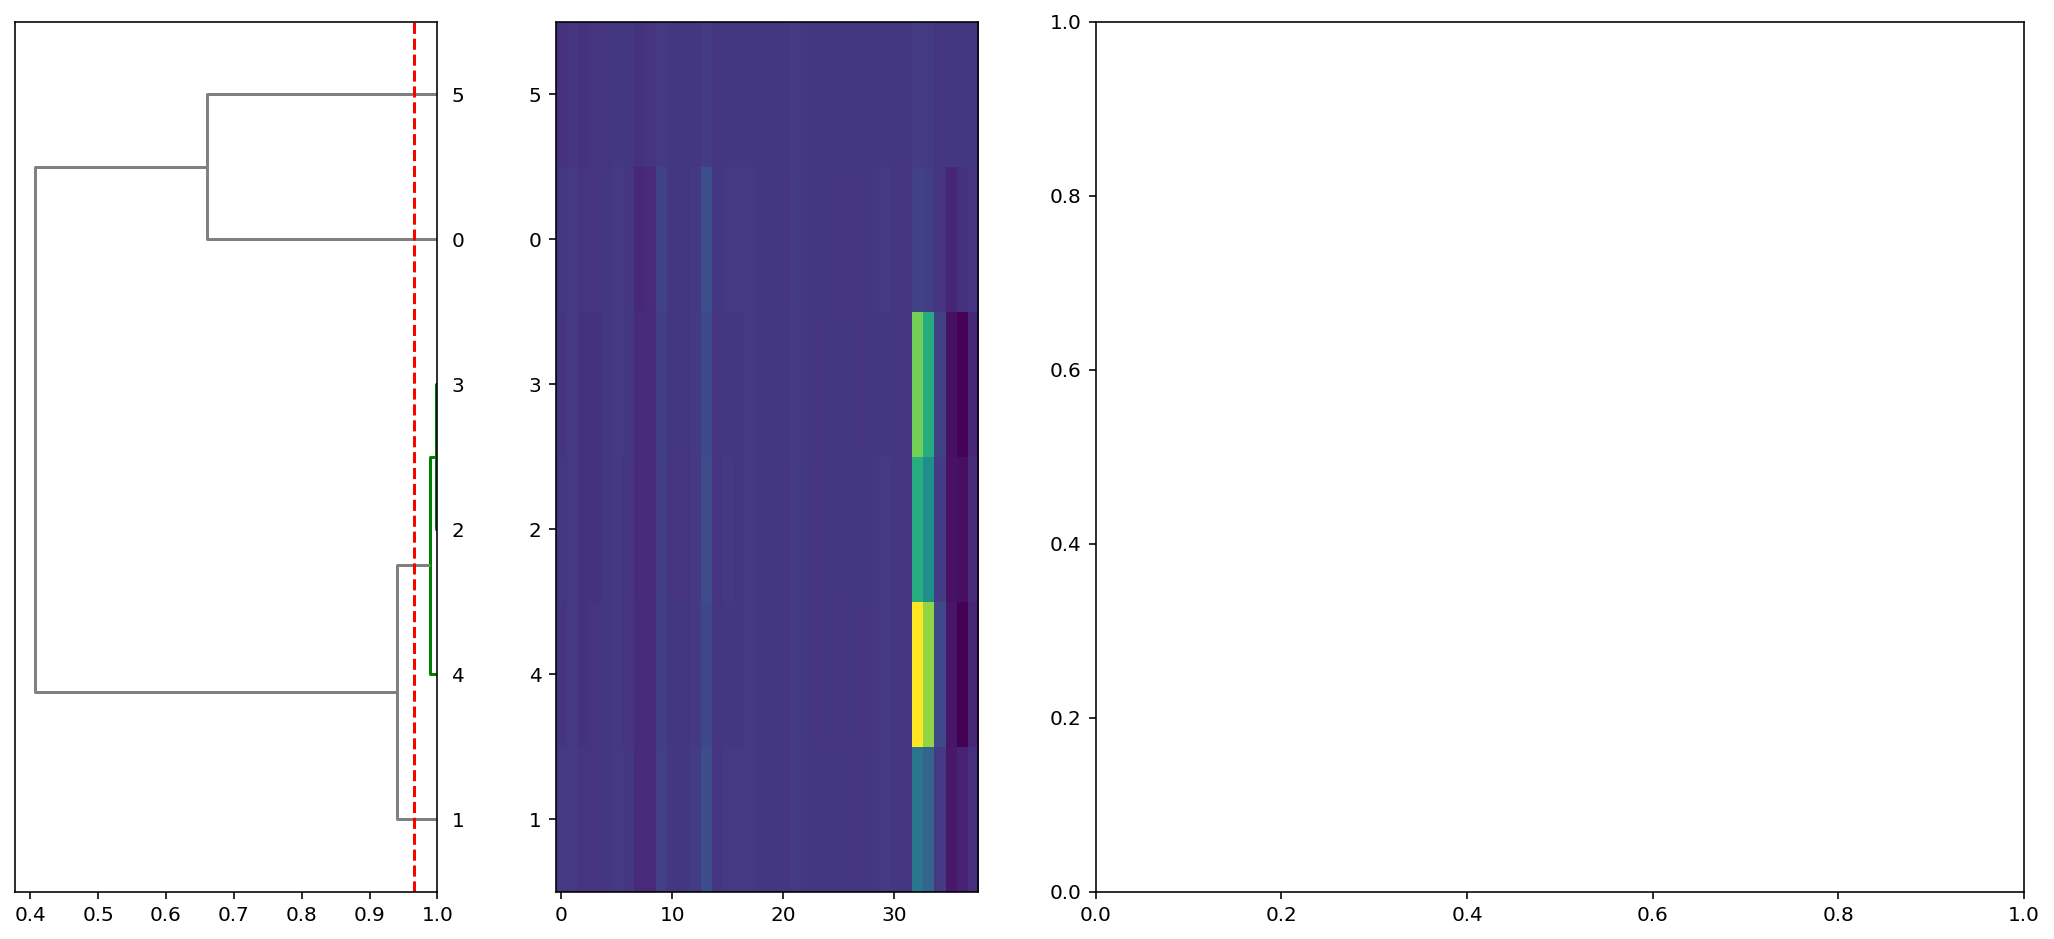

In [384]:
clst=clusterCutAndPlot(np.diff(rebin(x,10,1),1), mode="simple", threshold=4)

In [313]:
pws.shape

(2551, 196)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



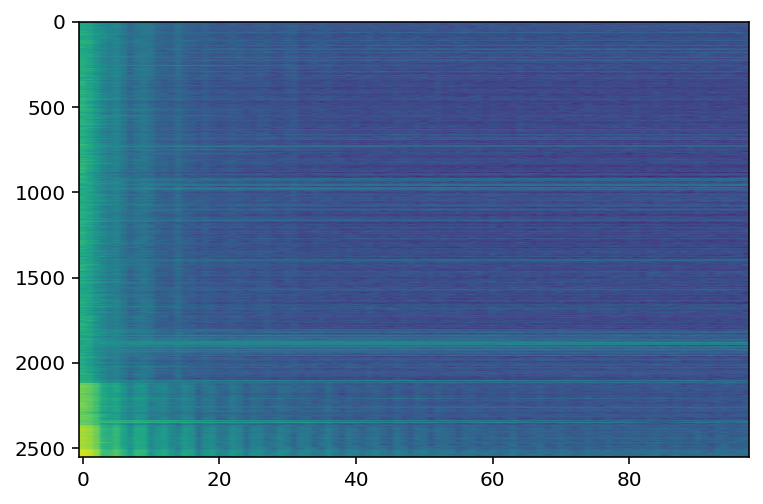

In [353]:
plt.imshow(np.vstack(np.abs(pws)[regions.df.clusterID==i] for i in sortedClusterIDs), aspect="auto", norm=LogNorm(vmin=1))

### New heading